In [6]:
import os
import csv
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import matplotlib
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

sys.path.append('../mcp')
from mcp_kegg import kegg_analysis

In [8]:
data_dir = '/Users/adaly/Documents/mouse_colon'

df_map = pd.read_csv('../data/Gene_names_mm.txt', sep='_', index_col=0, header=None, names=['common'])

### REPLACE with path to Bayes factor table downloaded from GCP ###
df_grad = pd.read_csv(os.path.join(data_dir, 'bayes_factors_crypt_gradient', 
                                   'bayes_factors_crypt_gradient_allages.csv'), index_col=0)
df_grad = df_grad.join(df_map, how='left', on='gene')

### Create (KEGG x time) dotplot showing enrichment of crypt gradient genes at each age

In [9]:
def kegg_scores_dotplot(df, df_size):
    # fill with zeros
    df = df.fillna(0).T
    df_size = df_size.fillna(0).T
    
    # Cut size array to 6 distinct values 
    df_size_cut = pd.cut(df_size.values.flatten() / max(df_size.values.flatten()), 6, 
                         include_lowest = False, labels = [0,0.2,0.4,0.6,0.8, 1.0])
    df_size_cut = pd.DataFrame(zip(*[iter(df_size_cut)]*len(df_size.columns)))
    labels_axis = np.array([0.2,0.4,0.6,0.8, 1.0]) * df_size.values.max()
    
    df_size_cut.columns = df.columns
    df_size_cut.index = df.index
    
    
    # define order
    cat_order = df_size_cut.index

    obs = pd.DataFrame(df.index, index = df.index, columns = ['KEGG pathway']).astype("category")
    mod_anndata = sc.AnnData(df, obs, dtype=np.float32)

    # plots
    vmin = 0
    vmax = 0.3
    cmap = 'Reds'

    plt.rcParams['font.size'] = 10
    size_title = '-log10(padj)'
    
    sc.pl.dotplot.DEFAULT_LEGENDS_WIDTH = 3.5
    
    ax_dict = sc.pl.dotplot(mod_anndata, show=False, var_names = mod_anndata.var_names, dot_size_df = df_size_cut, 
                            dot_color_df = df, categories_order = cat_order, size_title = size_title, 
                            colorbar_title = 'Overlap',
                            groupby = 'KEGG pathway', vmin = vmin, vmax = vmax, cmap=cmap, 
                            figsize = (2*len(mod_anndata.obs.columns)+3.5, len(mod_anndata.obs.index)),
                            swap_axes=True)
    
    ax_dict['mainplot_ax'].set_yticklabels([i for i in mod_anndata.var_names]) 
    ax_dict['mainplot_ax'].tick_params(axis='y', labelleft=True, left=True, labelsize = 8, 
                                       labelrotation = 0, pad = 0)   
    ax_dict['mainplot_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 10, 
                                       labelrotation = 90, pad = 0) 
    ax_dict['mainplot_ax'].grid(visible=True, which='major', axis='both')
    ax_dict['size_legend_ax'].set_facecolor('white')
    ax_dict['size_legend_ax'].set_aspect(0.2)
    ax_dict['size_legend_ax'].set_xticklabels(labels_axis)
    ax_dict['color_legend_ax'].set_aspect(0.2)
    fig = ax_dict['mainplot_ax'].get_figure()
    
    plt.subplots_adjust(left=0.5, right=1.0)
    #plt.tight_layout()
    
    return fig, ax_dict

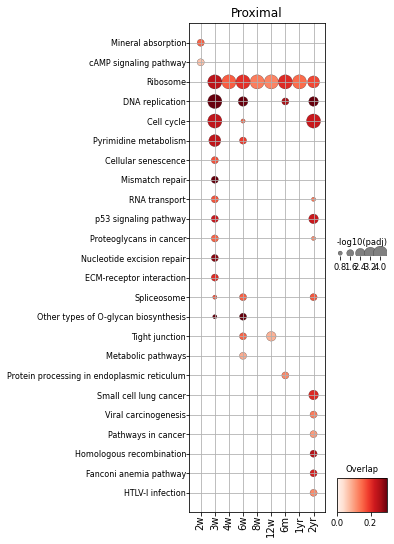

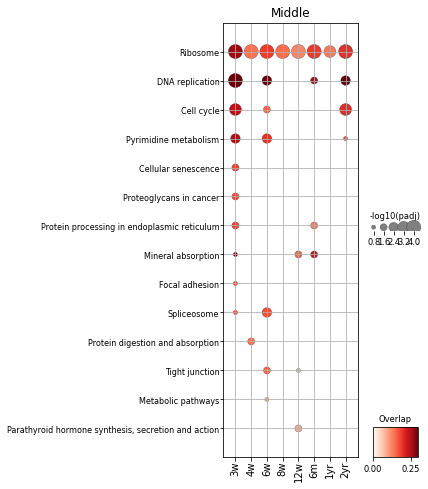

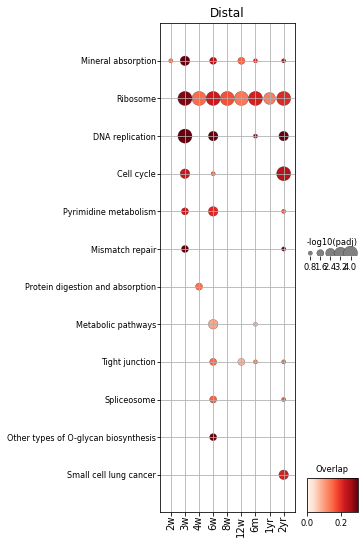

In [10]:
ages_ordered = ['0d', '1w', '2w', '3w', '4w', '6w', '8w', '12w', '6m', '1yr', '2yr']
regions = ['Proximal', 'Middle', 'Distal']

# Separately for each region:
for reg in regions:
    df_kegg_allages = None
    
    for age in ages_ordered:
        df = df_grad[np.logical_and(df_grad['Region']==reg, df_grad['Age']==age)]
        grad_genes = df['common'][df['grad_gene']]
        df_kegg = kegg_analysis(grad_genes)
        
        df_kegg.index = df_kegg['pathway']
        df_kegg.columns = [c+'_'+age for c in df_kegg.columns]
        
        if len(df_kegg) > 0:
            if df_kegg_allages is None:
                df_kegg_allages = df_kegg
            else:
                df_kegg_allages = df_kegg_allages.join(df_kegg, how='outer')
        
    df_padj = df_kegg_allages.loc[:, [c for c in df_kegg_allages.columns if c.startswith('p_adj')]]
    df_over = df_kegg_allages.loc[:, [c for c in df_kegg_allages.columns if c.startswith('overlap')]]
    
    # Rename columns to just reflect age
    df_padj.columns = [c.split('_')[2] for c in df_padj.columns]
    df_over.columns = [c.split('_')[1] for c in df_over.columns]
    
    # Remove KEGG pathways without significant association to at least one crypt gradient geneset
    filter_kegg = np.any(df_padj < 0.05, axis=1)
    df_padj = df_padj[filter_kegg]
    df_over = df_over[filter_kegg]
    
    # Negative log transform p_adj
    max_val = 4
    df_padj = np.minimum(-np.log10(df_padj), max_val)
    
    # Sort rows so that KEGG pathways are (roughly) ordered by age of importance
    df_padj.sort_values(list(df_padj.columns), ascending=False, inplace=True)
    df_over = df_over.loc[df_padj.index]
    
    fig, ax_dict = kegg_scores_dotplot(df_over, df_padj)
    ax_dict['mainplot_ax'].set_title(reg)
    plt.show()